##  Embedding  VS  One-hot

而在现实实际问题中，往往还会出现多值类别特征，用户的行为兴趣特征就是多值类别特征，也就是一个用户可以有多个类别的兴趣，比如打篮球，乒乓球和跳舞等，并且不同用户的兴趣个数不一样。
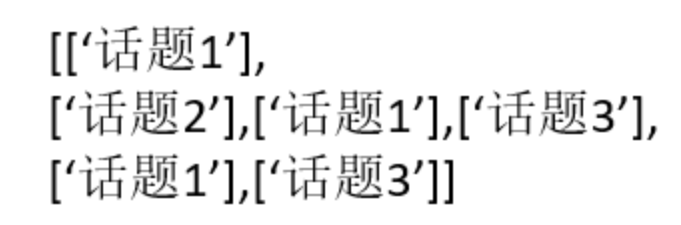

https://www.zhihu.com/question/364975182/answer/964728195

在CTR预估模型中，对这种多值类别特征的常用处理方法总结归纳如下：

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import re
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, Concatenate, Dropout, Input, Layer
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [3]:
def create_criteo_dataset(file_train, file_test, embed_dim=8, read_part=False, sample_num=100000, test_size=0.2):

    # 训练数据
    df_train = pd.read_csv(file_train)[1:20]
    # 测试数据
    df_apply_new = pd.read_csv(file_test)[1:20]
    # 合并训练集，验证集
    data_df = pd.concat([df_train, df_apply_new], axis=0, ignore_index=True)
    data_df['label'] = data_df['label'].fillna(str(-1))
    return data_df

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # log 标记输出

# you can modify your file path
file_train = '../../data/train.csv'
file_test = '../../data/apply_new.csv'


embed_dim = 12
read_part = True
sample_num = 6000000
test_size = 0.2

# ========================== Create dataset =======================
data = create_criteo_dataset(file_train=file_train,
                               file_test=file_test,
                               embed_dim=embed_dim,
                               read_part=read_part,
                               sample_num=sample_num,
                               test_size=test_size)

F:\Python\1\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
data.head()

,id,label,gender,age,appid,time,province,city,model,make
0,1295808,1,NaN,5,"[10577375,13567578,4437795,8934804,9352464,133...","[1.605842042532E12,1.592187596698E12,1.5598650...",广东,广州,OPPO,r11
1,1110160,0,NaN,NaN,"[11171956,9454883,9361934,10578048,10234462,12...","[1.607351673175E12,1.607351673175E12,1.6073516...",内蒙古,锡林郭勒盟,小米,小米 红米note2
2,1132597,0,NaN,2,"[4457927,9412324,12292192,9231799,11977927,852...","[1.56015519913E12,1.56015519913E12,1.582942163...",四川,成都,vivo,vivo x20
3,1108714,0,NaN,NaN,"[5737867,5105608,13792904,5454488,13098817,141...","[1.591494981671E12,1.616071068225E12,1.6160710...",湖南,长沙,vivo,x23
4,1131720,0,NaN,6,"[11580393,9297337,14074036,13068200,13669217,9...","[1.57270197744E12,1.55989435929E12,1.563934981...",广东,深圳,OPPO,a5


### 单变量one-hot

In [101]:
indices = [0, 2, 3, 1]
depth = 4
tf.one_hot(indices, depth,
           on_value=1.0, off_value=0.0,
           axis=-1) 

<tf.Tensor: id=376, shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)>

### Multi one hot

In [110]:
indices = [[0, 2, 3], [0, 1, 4]]
depth = 5
value = tf.one_hot(indices, depth,
           on_value=1.0, off_value=0.0,
           axis=-1) 
value

<tf.Tensor: id=408, shape=(2, 3, 5), dtype=float32, numpy=
array([[[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]]], dtype=float32)>

In [111]:
tf.reduce_sum(value,axis = 1)  # 按照 第二维度相加

<tf.Tensor: id=410, shape=(2, 5), dtype=float32, numpy=
array([[1., 0., 1., 1., 0.],
       [1., 1., 0., 0., 1.]], dtype=float32)>

这里使用非对等的长度的向量

In [130]:
indices = [[0, 2, 3], 
           [0, 1, 3]]

val = np.array(indices, )
val

array([[0, 2, 3],
       [0, 1, 3]])

### 单变量的 embedding

In [20]:
# LabelEncoder 的使用方法
le.fit([1, 2, 2, 6])
le.classes_
le.transform([1, 1, 2, 6])
le.inverse_transform([0, 0, 1, 2])

array([1, 1, 2, 6])

In [21]:
province_input_dim = len(data['province'].unique())

# 转化成label
le = LabelEncoder()
new = le.fit_transform(data['province'])
new

array([ 7,  0,  3, 13,  7,  7,  9,  3,  2,  3,  0,  7, 11, 13, 10, 15,  2,
       13, 16,  9,  3, 14,  8,  5, 12,  6,  8,  8,  4,  7, 11,  7,  7,  6,
        5,  1,  6,  7])

In [18]:
val = Embedding(input_dim=province_input_dim,
          input_length=1,
         output_dim=4,
         embeddings_initializer='random_uniform',
         embeddings_regularizer=l2(1e-4))

In [19]:
val(new)  # shape = [38, 4]

<tf.Tensor: id=61, shape=(38, 4), dtype=float32, numpy=
array([[ 0.02002538, -0.03097621,  0.01937643,  0.02634296],
       [-0.03806199,  0.03748211, -0.02555124, -0.04123473],
       [ 0.01157408,  0.04460679,  0.04581076, -0.04857717],
       [-0.04171075,  0.03527458,  0.00970881,  0.01712639],
       [ 0.02002538, -0.03097621,  0.01937643,  0.02634296],
       [ 0.02002538, -0.03097621,  0.01937643,  0.02634296],
       [-0.02247385, -0.03556406,  0.01296807, -0.02766054],
       [ 0.01157408,  0.04460679,  0.04581076, -0.04857717],
       [ 0.03497689, -0.03125197, -0.02802702,  0.02087862],
       [ 0.01157408,  0.04460679,  0.04581076, -0.04857717],
       [-0.03806199,  0.03748211, -0.02555124, -0.04123473],
       [ 0.02002538, -0.03097621,  0.01937643,  0.02634296],
       [-0.0161847 , -0.00541744,  0.04812862, -0.01068226],
       [-0.04171075,  0.03527458,  0.00970881,  0.01712639],
       [ 0.0241838 ,  0.01815859,  0.0197786 ,  0.01780209],
       [-0.00059064, -0.03353

### 多行输入 embedding

In [57]:
val = np.array([new, new])
val

array([[ 7,  0,  3, 13,  7,  7,  9,  3,  2,  3,  0,  7, 11, 13, 10, 15,
         2, 13, 16,  9,  3, 14,  8,  5, 12,  6,  8,  8,  4,  7, 11,  7,
         7,  6,  5,  1,  6,  7],
       [ 7,  0,  3, 13,  7,  7,  9,  3,  2,  3,  0,  7, 11, 13, 10, 15,
         2, 13, 16,  9,  3, 14,  8,  5, 12,  6,  8,  8,  4,  7, 11,  7,
         7,  6,  5,  1,  6,  7]])

In [60]:
embedding_val = Embedding(input_dim=province_input_dim,
          input_length=2,
         output_dim=4,
         embeddings_initializer='random_uniform',
         embeddings_regularizer=l2(1e-4))
embedding_val(val)

<tf.Tensor: id=260, shape=(2, 38, 4), dtype=float32, numpy=
array([[[ 0.00992273,  0.04978886,  0.02681528,  0.00412451],
        [-0.01516677, -0.02053169,  0.03437886,  0.00536082],
        [ 0.04417108,  0.00951697,  0.02696136,  0.03508301],
        [-0.0488698 , -0.03478614, -0.04516101, -0.01671171],
        [ 0.00992273,  0.04978886,  0.02681528,  0.00412451],
        [ 0.00992273,  0.04978886,  0.02681528,  0.00412451],
        [ 0.02990038,  0.02851028, -0.0309087 ,  0.00525103],
        [ 0.04417108,  0.00951697,  0.02696136,  0.03508301],
        [-0.01601621, -0.00417805,  0.03989794,  0.00948675],
        [ 0.04417108,  0.00951697,  0.02696136,  0.03508301],
        [-0.01516677, -0.02053169,  0.03437886,  0.00536082],
        [ 0.00992273,  0.04978886,  0.02681528,  0.00412451],
        [-0.02793024,  0.0359943 ,  0.02527868, -0.02319238],
        [-0.0488698 , -0.03478614, -0.04516101, -0.01671171],
        [ 0.00397183, -0.00499171,  0.02385387,  0.02223751],
        [ 

### embedding 接受 multi one hot 的输入

In [89]:
indices = [[0, 2, 3], [0, 1, 4]]
depth = 5
value = tf.one_hot(indices, depth,
           on_value=1.0, off_value=0.0,
           axis=-1) 
res = tf.reduce_sum(value,axis = 1)  # 按照 第二维度相加
res

<tf.Tensor: id=328, shape=(2, 5), dtype=float32, numpy=
array([[1., 0., 1., 1., 0.],
       [1., 1., 0., 0., 1.]], dtype=float32)>

In [87]:
embedding_val(res)

<tf.Tensor: id=313, shape=(2, 5, 4), dtype=float32, numpy=
array([[[-0.00436312,  0.01337645, -0.01903743, -0.01986262],
        [-0.01516677, -0.02053169,  0.03437886,  0.00536082],
        [-0.00436312,  0.01337645, -0.01903743, -0.01986262],
        [-0.00436312,  0.01337645, -0.01903743, -0.01986262],
        [-0.01516677, -0.02053169,  0.03437886,  0.00536082]],

       [[-0.00436312,  0.01337645, -0.01903743, -0.01986262],
        [-0.00436312,  0.01337645, -0.01903743, -0.01986262],
        [-0.01516677, -0.02053169,  0.03437886,  0.00536082],
        [-0.01516677, -0.02053169,  0.03437886,  0.00536082],
        [-0.00436312,  0.01337645, -0.01903743, -0.01986262]]],
      dtype=float32)>

## appid
处理 appid 降维成8维

（1） 统计appid 中有多少个不同的值

In [153]:
val = str(data['appid'].values)

In [154]:
# 2. 简单对数据进行清洗
def clean_data(string):
    # 对数据清洗
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    return string.strip().lower()

In [155]:
value = clean_data(val)
value_1 = re.findall(r'\d+',value)  # 获取字符串中的数字

In [157]:
value_int = list(map(int, value_1))
value_int

[10577375,
 13567578,
 4437795,
 8934804,
 9352464,
 13329883,
 14074036,
 12814015,
 10882324,
 10635783,
 13746317,
 12185778,
 11210750,
 13068200,
 12936701,
 11871458,
 5421529,
 10223866,
 12014730,
 11228680,
 10560059,
 12826736,
 10743677,
 897079,
 1711333,
 12164649,
 4947381,
 11580393,
 11333156,
 2404206,
 12574914,
 10839574,
 4051662,
 11366521,
 8937716,
 13669217,
 10401342,
 10716404,
 9297337,
 10578048,
 5674849,
 13343061,
 9361934,
 11180532,
 13594132,
 11219658,
 11141111,
 13347466,
 10715729,
 10749246,
 9808890,
 4453282,
 10668512,
 4051674,
 10234462,
 12968243,
 8946402,
 8813172,
 12163016,
 11035589,
 10988354,
 10755102,
 11171956,
 9454883,
 9361934,
 10578048,
 10234462,
 12546375,
 10580614,
 10581071,
 11578845,
 12496306,
 4456880,
 12307958,
 12576876,
 13669217,
 13343061,
 10982847,
 8839718,
 11219658,
 10563560,
 12522328,
 9454876,
 10577316,
 11407200,
 4437795,
 9952871,
 12410356,
 10580542,
 10580633,
 11228680,
 14061353,
 10096286,
 10

In [7]:
matrix = [[1],
          [1,2],
          [1,2,3],
          [1,2,3,4],
          [1,2,3,4,5],
          [3,4,5],
          [2,3,4,5],
          ]
#现在需要将矩阵中所有的列表长度对齐到最长的列表的长度5，末尾全部用0填充
max_len = max((len(l) for l in matrix))
new_matrix = list(map(lambda l:l + [0]*(max_len - len(l)), matrix))
print(new_matrix)

[[1, 0, 0, 0, 0], [1, 2, 0, 0, 0], [1, 2, 3, 0, 0], [1, 2, 3, 4, 0], [1, 2, 3, 4, 5], [3, 4, 5, 0, 0], [2, 3, 4, 5, 0]]
